In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np  
from flopy.utils.lgrutil import Lgr ; from matplotlib.colors import ListedColormap ; from pathlib import Path
from flopy.plot.styles import styles ; import pandas as pd ; from modflow_devtools.misc import get_env, timed

In [2]:
write=get_env("WRITE", True);run=get_env("RUN", True);plot=get_env("PLOT", True)
plot_show=get_env("PLOT_SHOW", True);plot_save = get_env("PLOT_SAVE", True)  

In [3]:
sim_name = "08_p02" ; output_folder = Path("./08_ex-gwf-nwt-p02") ; output_folder.mkdir(exist_ok=True) 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name 
output_folder2 = output_folder/'08_p02a'; name = sim_name                        ; length_units="feet" ; time_units="days" 
output_folder3 = output_folder/'08_p02b'

In [4]:
parameters = {"08_p02a": {"newton": "newton",},
              "08_p02b": {"rewet": True,"wetfct": 0.5,"iwetit": 1,"ihdwet": 1,"wetdry": -0.5}}     

nper = 4 ;  nlay = 14 ;  nrow = 40 ;  ncol = 40 ;  delr = 125 ;  delc = 125 ;  top = 80 ;  k11 = 5 ;  k33 = 0.25   
ss = 0.0002 ;  sy = 0.2 ;  H1 = 25 ;  rech = 0.05 ;  nouter = 500 ;  ninner = 100 ;  hclose = 0.000001 ;  rclose = 1000   

tdis_ds = ((190.0, 10, 1.0),(518.0, 2, 1.0),(1921.0, 17, 1.0),(1.0, 1, 1.0))  ; extents = (0, delr * ncol, 20, 65)
shape3d = (nlay, nrow, ncol)  ; botm = np.arange(65.0, -5.0, -5.0)  ; icelltype = 9 * [1] + 5 * [0]  ; chd_spd = []
for k in range(9, nlay, 1):
    chd_spd += [[k, i, ncol - 1, H1] for i in range(nrow - 1)] ; chd_spd += [[k, nrow - 1, j, H1] for j in range(ncol)]
rch_spd = []
for i in range(0, 2, 1):
    for j in range(0, 2, 1):
        rch_spd.append([0, i, j, rech])

In [5]:
def build_models(name, newton=False, rewet=False, wetfct=None, iwetit=None, ihdwet=None, wetdry=None):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    if newton:
        newtonoptions = "newton" ; no_ptc = "ALL" ; complexity = "complex"
    else:
        newtonoptions = None ; no_ptc = None ; complexity = "simple"
    flopy.mf6.ModflowIms(sim, complexity=complexity, print_option="SUMMARY", no_ptcrecord=no_ptc, outer_maximum=nouter, 
                         outer_dvclose=hclose, inner_maximum=ninner, inner_dvclose=hclose,rcloserecord=rclose)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions=newtonoptions)
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    if rewet:
        rewet_record = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet] ; wetdry = 9 * [wetdry] + 5 * [0]
    else:
        rewet_record = None
    flopy.mf6.ModflowGwfnpf(gwf,rewet_record=rewet_record,icelltype=icelltype,k=k11,k33=k33,wetdry=wetdry)
    flopy.mf6.ModflowGwfsto(gwf,iconvert=icelltype,ss=ss,sy=sy,steady_state={3: True})
    flopy.mf6.ModflowGwfic(gwf, strt=H1)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rch_spd)
    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,saverecord=[("HEAD", "ALL")]) # LAST
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

In [6]:
def get_water_table(h, bot):
    imask = (h > -1e30) & (h <= bot) ; h[imask] = -1e30            ; return np.amax(h, axis=0)
def plot_results(silent=True):
    if not plot:
        return
    with styles.USGSMap():
        
        name = next(iter(parameters.keys()))                                             ; sim_ws = os.path.join(workspace, name)    
        sim = flopy.mf6.MFSimulation.load(sim_name = sim_name, sim_ws=sim_ws, verbosity_level=0)
        gwf = sim.get_model(sim_name)               ; bot   = gwf.dis.botm.array                
        xnode = gwf.modelgrid.xcellcenters[0, :]    ; hobj  = gwf.output.head ()         ; times = hobj.get_times()
        
        name = list(parameters.keys())[1]                                                ; sim_ws = os.path.join(workspace, name)   
        sim1 = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=sim_ws, verbosity_level=0)
        gwf1 = sim1.get_model(sim_name)             ; hobj1 = gwf1.output.head()

        fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(6.3, 6.3), constrained_layout=False)
        for idx, ax in enumerate(axes):
            head  = hobj.get_data (totim=times[idx])  ; head = get_water_table (head, bot)
            head1 = hobj1.get_data(totim=times[idx])  ; head1 = get_water_table(head1, bot)

            diff = np.abs(head - head1)    ; me = diff.sum()/float(ncol * nrow)  ; me_text = f"Mean absolute water-table error {me:.3f} feet"

            ax.set_xlim(extents[:2])  ; ax.set_ylim(extents[2:])
            mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, extent=extents, line={"row": 1}) ; mm.plot_bc("CHD", color="cyan") ; mm.plot_grid(lw=0.5)
            ax.plot(xnode, head[0, :], lw=0.75, color="black", label="Newton-Raphson")
            ax.plot(xnode,head1[0, :],lw=0,marker="o",ms=4,mfc="none",mec="blue",label="Rewetting")
            if idx == 0:
                ax.plot(-1000,-1000,lw=0,marker="s",ms=4,mec="0.5",mfc="none",label="Model cell")
                ax.plot(-1000,-1000,lw=0,marker="s",ms=4,mec="0.5",mfc="cyan",label="Constant head")
                styles.graph_legend(ax,loc="upper right",ncol=2,frameon=True,facecolor="white",edgecolor="none")
            letter = chr(ord("@") + idx + 1) ; styles.heading(letter=letter, ax=ax)  
            styles.add_text(ax, text=me_text, x=1, y=1.01, ha="right", bold=False) ; styles.remove_edge_ticks(ax) ; ax.set_ylabel(" ")
        
        ax.set_xlabel(" ") ; ax = fig.add_subplot(1, 1, 1, frameon=False)
        ax.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off") ; ax.set_xlim(0, 1) ; ax.set_xticks([0, 1])
        ax.set_xlabel("x-coordinate, in feet") ; ax.set_ylim(0, 1) ; ax.set_yticks([0, 1])
        ax.set_ylabel("Water-table elevation above arbitrary datum, in meters") ; styles.remove_edge_ticks(ax)
        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"  ; fig.savefig(fpth)

In [7]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]   ; params = parameters[key].copy()  ; sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

Run with Newton-Raphson.

In [8]:
scenario(0)

run_models took 9633.55 ms


Run with rewetting.

In [9]:
scenario(1)

run_models took 4177.63 ms


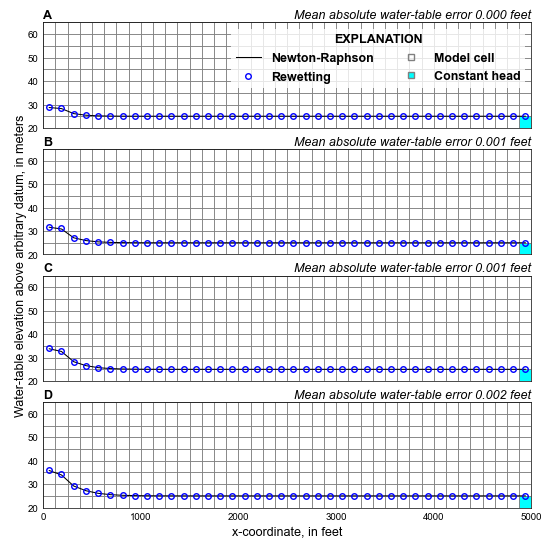

In [10]:
if plot:
    plot_results()

In [11]:
sim = flopy.mf6.MFSimulation.load(sim_name = sim_name, sim_ws=output_folder2, verbosity_level=0)
gwf = sim.get_model(sim_name)             ; bot = gwf.dis.botm.array                
xnode = gwf.modelgrid.xcellcenters[0, :]  ; hobj = gwf.output.head()                ; times = hobj.get_times()                

sim1 = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=output_folder3, verbosity_level=0)
gwf1 = sim1.get_model(sim_name)           ; hobj1 = gwf1.output.head()

In [15]:
tdis_ds

((190.0, 10, 1.0), (518.0, 2, 1.0), (1921.0, 17, 1.0), (1.0, 1, 1.0))

In [17]:
print('times  = ',  times)

times  =  [19.0, 38.0, 57.0, 76.0, 95.0, 114.0, 133.0, 152.0, 171.0, 190.0, 449.0, 708.0, 821.0, 934.0, 1047.0, 1160.0, 1273.0, 1386.0, 1499.0, 1612.0, 1725.0, 1838.0, 1951.0, 2064.0, 2177.0, 2290.0, 2403.0, 2516.0, 2629.0, 2630.0]


In [13]:
hobj

In [14]:
hobj1